In [1]:
# Importing required libraries and modules
import matplotlib.pyplot as plt
from glob import glob # to create a list of all the files present in a directory
import cv2
import random # to choose anything in random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
# convo2d is used to read images and learn features from them.
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from IPython.display import SVG, Image
import tensorflow as tf 
print("tensorflow version: ",tf.__version__)

2024-02-26 12:19:22.807700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 12:19:22.807827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 12:19:22.949668: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow version:  2.15.0


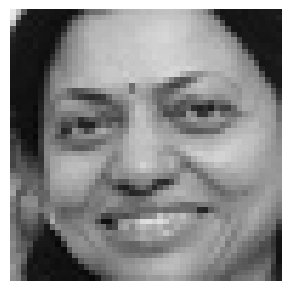

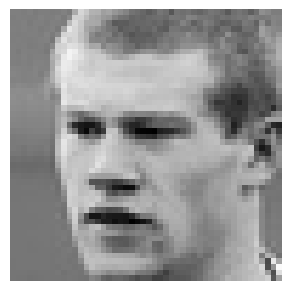

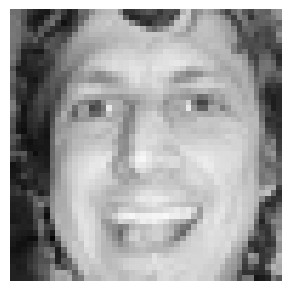

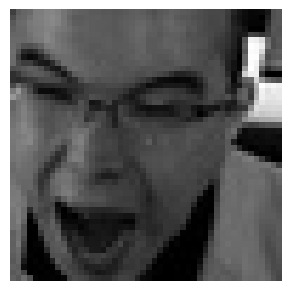

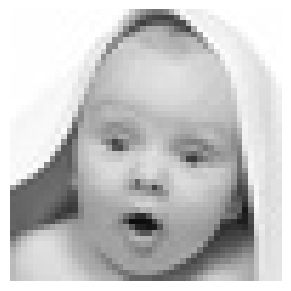

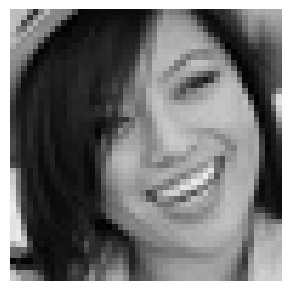

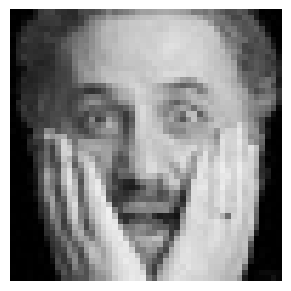

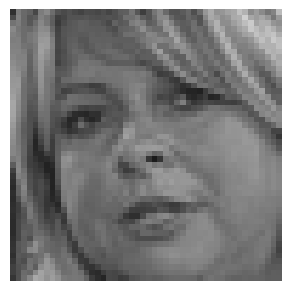

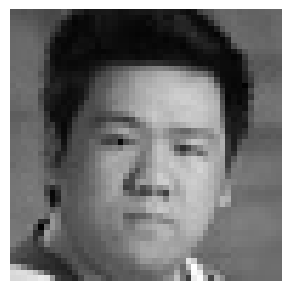

In [2]:
# Exploring Dataset
images=glob("/kaggle/input/fer2013/train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

In [3]:
# Preparing data for training
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip=True)
train_gen = datagen_train.flow_from_directory("/kaggle/input/fer2013/train/",target_size = (img_size,img_size),color_mode="grayscale",batch_size=batch_size,class_mode="categorical",shuffle=True)

# same for test data
datagen_validation = ImageDataGenerator(horizontal_flip=True)
train_validation = datagen_train.flow_from_directory("/kaggle/input/fer2013/test/",target_size = (img_size,img_size),color_mode="grayscale",batch_size=batch_size,class_mode="categorical",shuffle=True)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# Defining model
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters,kernel_size=kernel_size,padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)

    return x

In [5]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [7]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_i = Convolution(inputs,64,(3,3))
    conv_ii = Convolution(conv_i,128,(5,5))
    conv_iii = Convolution(conv_ii,512,(3,3))
    conv_iv = Convolution(conv_iii,512,(3,3))

    flatten = Flatten()(conv_iv)

    dense_i = Dense_f(flatten,256)
    dense_ii = Dense_f(dense_i,512)
    output = Dense(7,activation="softmax")(dense_ii)
    model = Model(inputs=[inputs], outputs=[output])
    
    opt = Adam(lr=0.0005)

    model.compile(loss=['categorical_crossentropy'], optimizer=opt, metrics=['accuracy'])

    return model

In [8]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0     

In [10]:
# Initializing the model
epochs = 15
steps_per_epoch = train_gen.n//train_gen.batch_size
validation_steps = train_validation.n//train_validation.batch_size
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=2, min_lr=0.00001)
callbacks = [checkpoint,reduce_lr]

In [11]:
# Training the model
history = model.fit(x= train_gen, steps_per_epoch= steps_per_epoch, epochs=epochs, validation_data=train_validation, validation_steps=validation_steps, callbacks=callbacks)


Epoch 1/15


2024-02-26 12:27:55.426570: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708950479.196269     268 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


448/448 [==============================] - ETA: 0s - loss: 1.7307 - accuracy: 0.3348
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 141s 294ms/step - loss: 1.7307 - accuracy: 0.3348 - val_loss: 2.4733 - val_accuracy: 0.3101 - lr: 0.0010
Epoch 2/15
447/448 [============================>.] - ETA: 0s - loss: 1.3855 - accuracy: 0.4671
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 31s 70ms/step - loss: 1.3850 - accuracy: 0.4673 - val_loss: 1.4807 - val_accuracy: 0.4443 - lr: 0.0010
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.2585 - accuracy: 0.5198
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 31s 68ms/step - loss: 1.2585 - accuracy: 0.5198 - val_loss: 1.2303 - val_accuracy: 0.5233 - lr: 0.0010
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.1921 - accuracy: 0.5448
Epoch 4: saving model to model_weights.h5
448/448 [==========

In [12]:
# Model evaluation
model.evaluate(train_validation)

113/113 [==============================] - 6s 57ms/step - loss: 0.9863 - accuracy: 0.6325


[0.9863303303718567, 0.6324881315231323]

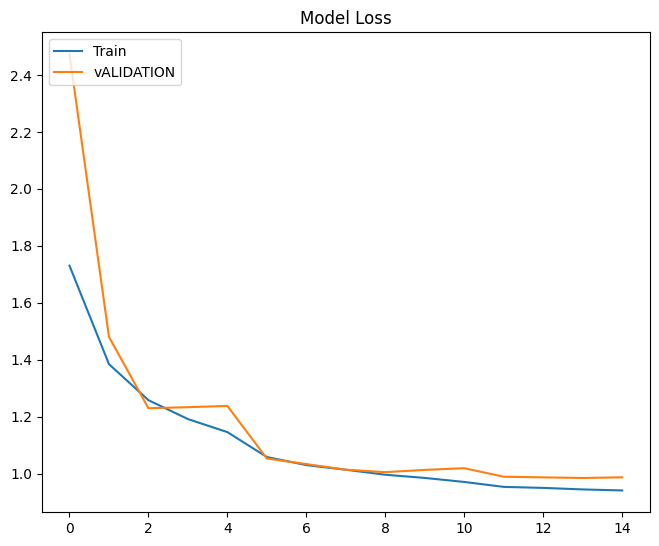

In [13]:
# Plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.legend(["Train","vALIDATION"],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)


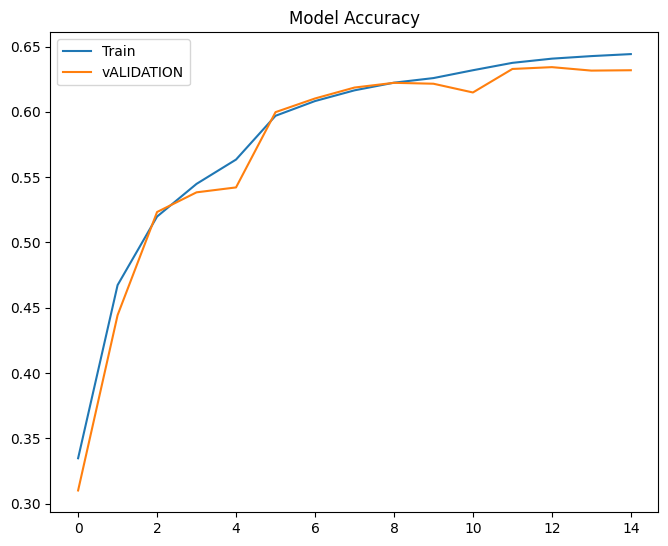

In [14]:
# Plotting Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.legend(["Train","vALIDATION"],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

In [15]:
# Save the Model Architecture
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)